# Armenian Stone Inscription - Interactive Parameter Tuning
## Step-by-Step Pipeline with Visual Feedback



---
## Setup: Import Libraries

In [1]:
import numpy as np
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import morphology, measure
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Paths
IMAGE_DIR = Path('../Images')
RESULTS_DIR = Path('../Results')

# Helper function to display images
def show(img, title='', cmap='gray', figsize=(12, 8)):
    """Display image with title"""
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_compare(img1, img2, title1='Before', title2='After', cmap='gray', figsize=(16, 7)):
    """Show two images side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img1, cmap=cmap)
    ax1.set_title(title1, fontsize=12, fontweight='bold')
    ax1.axis('off')
    ax2.imshow(img2, cmap=cmap)
    ax2.set_title(title2, fontsize=12, fontweight='bold')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

def show_grid(images, titles, cols=3, figsize=(15, 10), cmap='gray'):
    """Show multiple images in grid"""
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.axis('off')
    
    for ax in axes[len(images):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Helper functions defined")

✓ Helper functions defined


---
## Step 0: Load Images and Select One

In [3]:
# Find all images
image_files = sorted(list(IMAGE_DIR.glob('*.jpg')) + 
                    list(IMAGE_DIR.glob('*.png')) + 
                    list(IMAGE_DIR.glob('*.jpeg')))

print(f"Found {len(image_files)} images:")
for i, f in enumerate(image_files):
    print(f"  {i}: {f.name}")

# Load all images
images = {}
for f in image_files:
    img = cv2.imread(str(f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    images[f.stem] = {'color': img, 'gray': img_gray}

print("\n✓ All images loaded")

Found 4 images:
  0: Image1.png
  1: Image2.jpeg
  2: Image3.jpg
  3: Image4.jpg

✓ All images loaded


Selected: Image1
Size: (768, 1369)


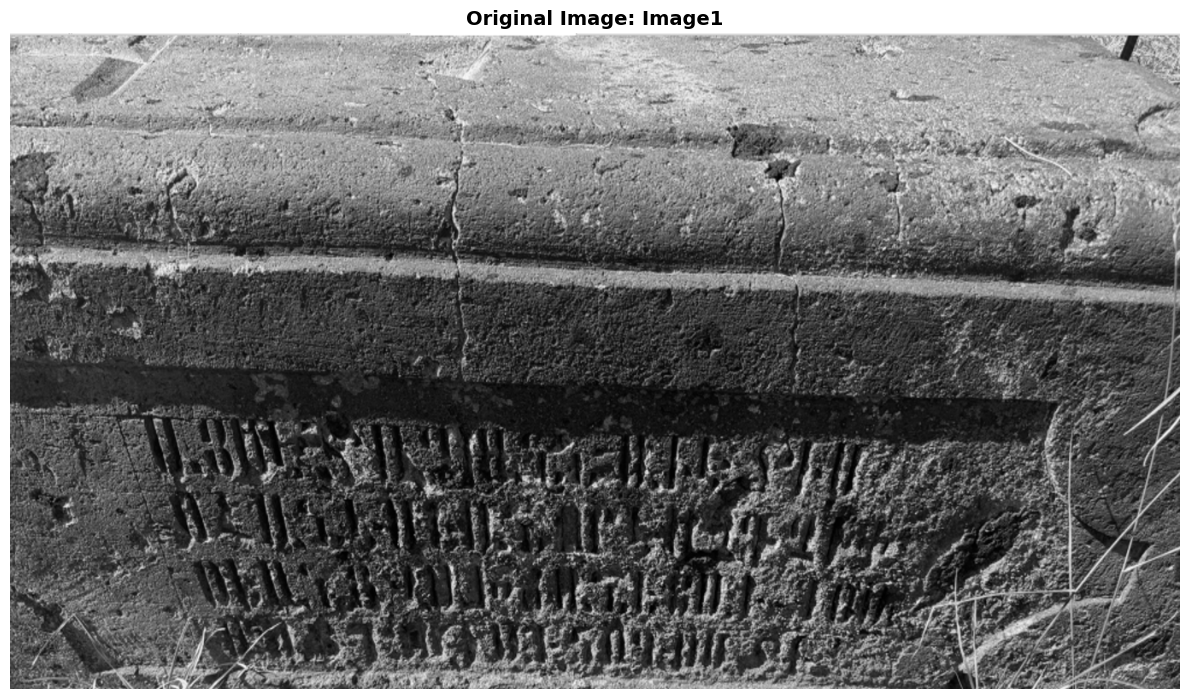

In [4]:
# SELECT IMAGE TO PROCESS
# Change this to process a different image: 'Image1', 'Image2', 'Image3', 'Image4'
SELECTED_IMAGE = 'Image1'

# Get the selected image
if SELECTED_IMAGE in images:
    original_color = images[SELECTED_IMAGE]['color']
    original_gray = images[SELECTED_IMAGE]['gray']
    print(f"Selected: {SELECTED_IMAGE}")
    print(f"Size: {original_gray.shape}")
    show(original_gray, f'Original Image: {SELECTED_IMAGE}', figsize=(12, 8))
else:
    print(f"Error: {SELECTED_IMAGE} not found!")
    print(f"Available images: {list(images.keys())}")

---
## Step 1: Vertical Edge Detection

**Goal:** Detect vertical edges (Armenian letters have dominant vertical strokes)

**Parameters to adjust:**
- `edge_threshold`: Higher = fewer edges, Lower = more edges
- Typical range: 20-60

Edge Threshold: 20
Edge pixels: 799,475 (76.04%)


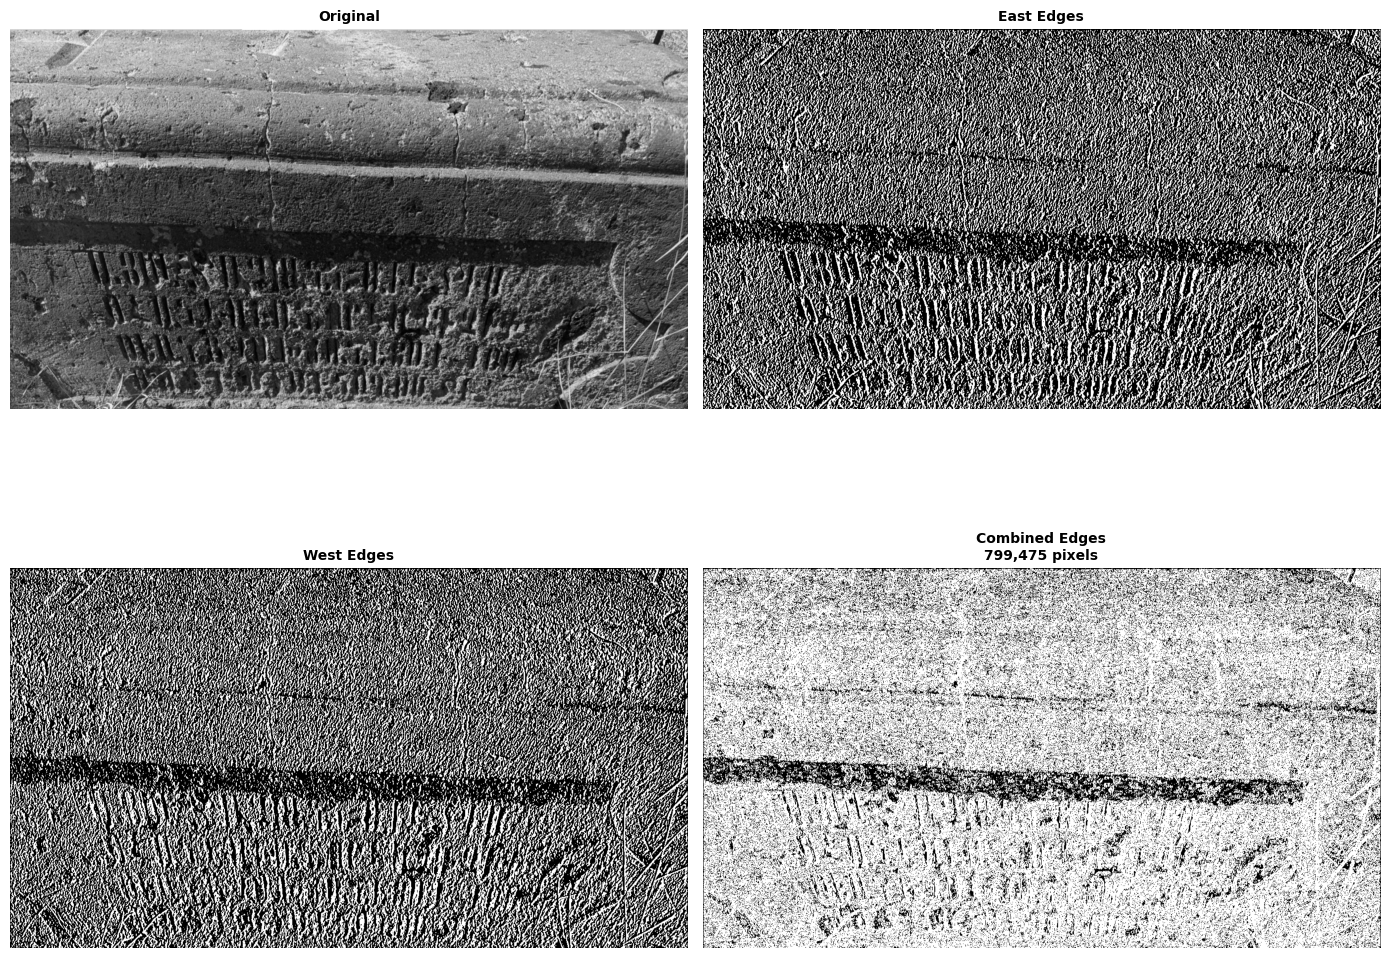

In [16]:
# ADJUST PARAMETER HERE
edge_threshold = 20  # Try: 20, 30, 40, 50

# Sobel kernels for vertical edge detection
sobel_east = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
sobel_west = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=np.float32)

# Apply Sobel filters
east_response = cv2.filter2D(original_gray, -1, sobel_east)
west_response = cv2.filter2D(original_gray, -1, sobel_west)

# Compute magnitude and threshold
east_edges = (np.abs(east_response) > edge_threshold).astype(np.uint8) * 255
west_edges = (np.abs(west_response) > edge_threshold).astype(np.uint8) * 255
combined_edges = cv2.bitwise_or(east_edges, west_edges)

# Statistics
edge_pixels = np.sum(combined_edges > 0)
edge_percent = edge_pixels / combined_edges.size * 100

print(f"Edge Threshold: {edge_threshold}")
print(f"Edge pixels: {edge_pixels:,} ({edge_percent:.2f}%)")

# Visualize
show_grid(
    [original_gray, east_edges, west_edges, combined_edges],
    ['Original', f'East Edges', f'West Edges', f'Combined Edges\n{edge_pixels:,} pixels'],
    cols=2, figsize=(14, 12)
)

**Evaluation:**
- ✓ Good: Clear vertical strokes visible, minimal noise
- ✗ Too many edges: Increase `edge_threshold`
- ✗ Too few edges: Decrease `edge_threshold`

---
## Step 2: Morphological Enhancement

**Goal:** Connect nearby vertical strokes horizontally, remove vertical noise

**Parameters:**
- `morph_iterations`: Number of dilation/erosion iterations
- Typical range: 1-3

Morphology iterations: 1
Before: 799,475 pixels
After: 948,062 pixels
Change: +148,587 pixels


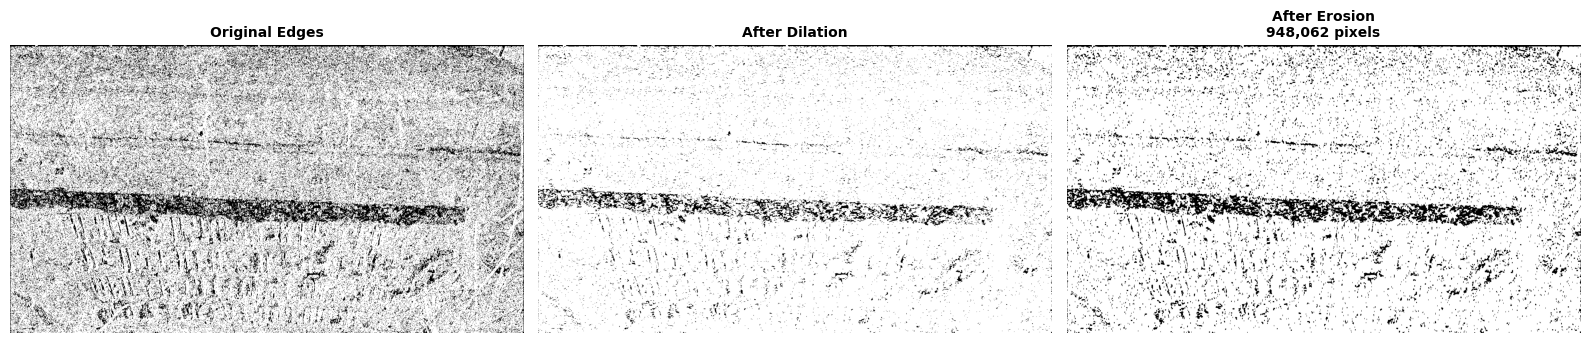

In [18]:
# ADJUST PARAMETER HERE
morph_iterations = 1  # Try: 1, 2, 3

# Structuring elements
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))

# Horizontal dilation (connect horizontally)
dilated = cv2.dilate(combined_edges, horizontal_kernel, iterations=morph_iterations)

# Vertical erosion (remove vertical noise)
morphed = cv2.erode(dilated, vertical_kernel, iterations=morph_iterations)

# Statistics
morph_pixels = np.sum(morphed > 0)
print(f"Morphology iterations: {morph_iterations}")
print(f"Before: {edge_pixels:,} pixels")
print(f"After: {morph_pixels:,} pixels")
print(f"Change: {morph_pixels - edge_pixels:+,} pixels")

# Visualize
show_grid(
    [combined_edges, dilated, morphed],
    ['Original Edges', f'After Dilation', f'After Erosion\n{morph_pixels:,} pixels'],
    cols=3, figsize=(16, 6)
)

**Evaluation:**
- ✓ Good: Vertical strokes connected into horizontal regions
- ✗ Too fragmented: Increase `morph_iterations`
- ✗ Over-connected: Decrease `morph_iterations`

---
## Step 3: Denoising

**Goal:** Remove small noise while preserving text structures

**Parameters:**
- `denoise_kernel`: Median filter kernel size (must be odd)
- Typical values: 3, 5, 7

In [23]:
# ADJUST PARAMETER HERE
denoise_kernel = 5  # Try: 3, 5, 7

# Apply median filter
filtered = cv2.medianBlur(morphed, denoise_kernel)

# Re-binarize (CRITICAL for maintaining binary image)
denoised = (filtered > 127).astype(np.uint8) * 255

# Statistics
denoised_pixels = np.sum(denoised > 0)
noise_removed = morph_pixels - denoised_pixels
print(f"Denoise kernel: {denoise_kernel}")
print(f"Before: {morph_pixels:,} pixels")
print(f"After: {denoised_pixels:,} pixels")
print(f"Noise removed: {noise_removed:,} pixels")

# Visualize
show_compare(
    morphed, denoised,
    f'Before Denoising\n{morph_pixels:,} pixels',
    f'After Denoising (kernel={denoise_kernel})\n{denoised_pixels:,} pixels'
)

Denoise kernel: 5
Before: 948,062 pixels
After: 990,274 pixels
Noise removed: -42,212 pixels


**Evaluation:**
- ✓ Good: Clean edges, text regions preserved
- ✗ Still noisy: Increase `denoise_kernel`
- ✗ Lost detail: Decrease `denoise_kernel`

---
## Step 4: Bandpass Filter (Frequency Domain)

**Goal:** Remove background gradients (low freq) and pixel noise (high freq)

**Parameters:**
- `filter_large`: Remove structures larger than this (pixels) - affects background
- `filter_small`: Remove structures smaller than this (pixels) - affects noise
- Typical: large=20-80, small=2-5

Bandpass filter: large=40, small=30
Low cutoff frequency: 9.60
High cutoff frequency: 12.80


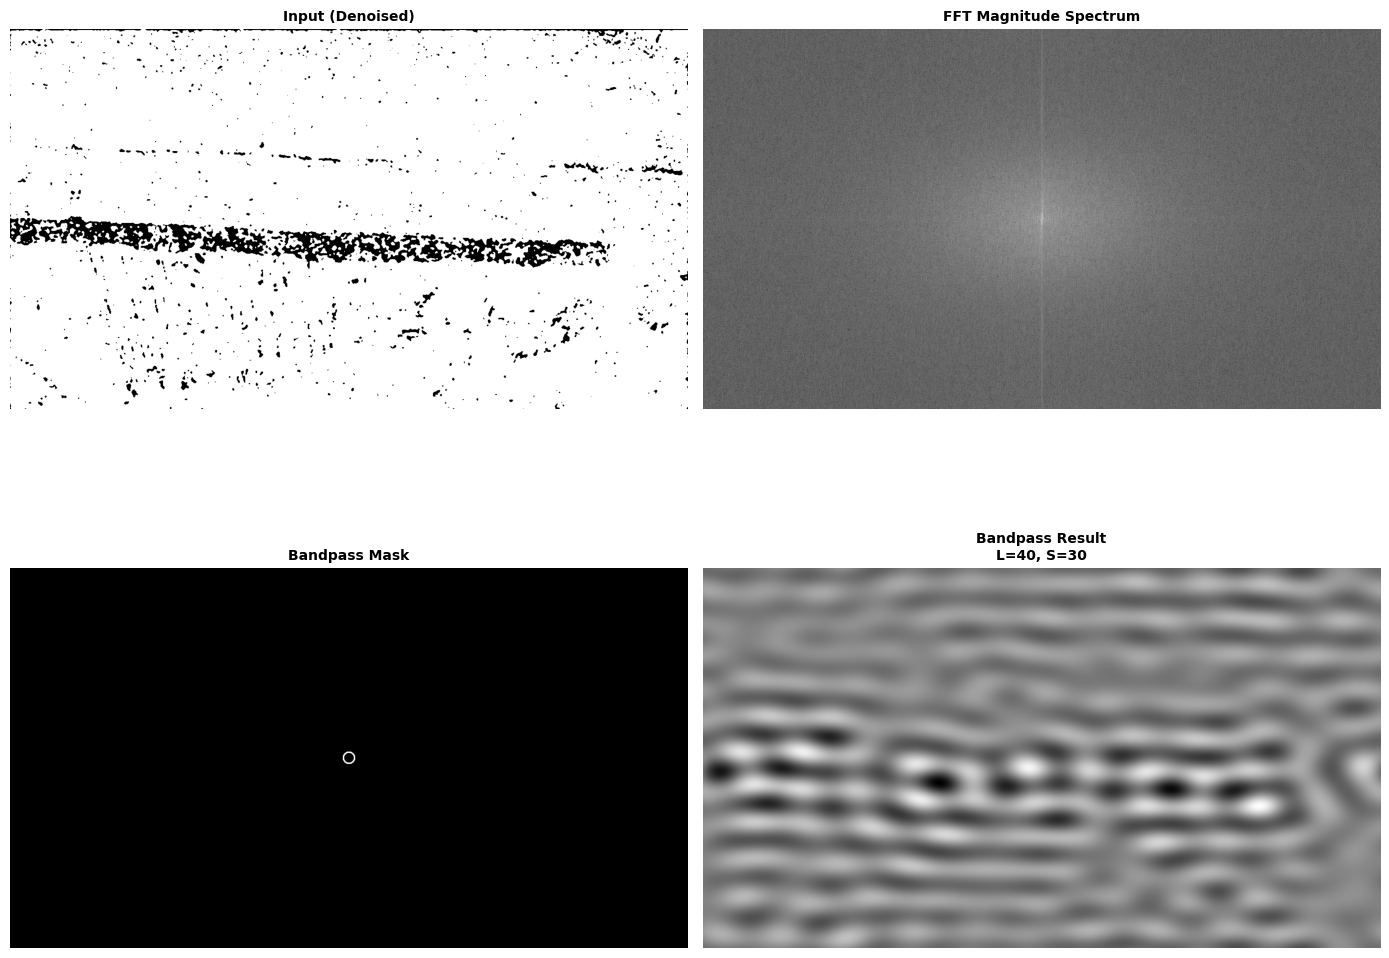

In [24]:
# ADJUST PARAMETERS HERE
filter_large = 40  # Try: 20, 40, 60, 80
filter_small = 30   # Try: 2, 3, 4, 5

# Convert to float
img_float = denoised.astype(np.float32)

# Compute 2D FFT
fft = fft2(img_float)
fft_shift = fftshift(fft)  # Center DC component

# Create bandpass mask
rows, cols = denoised.shape
crow, ccol = rows // 2, cols // 2
mask = np.zeros((rows, cols), np.float32)

# Calculate frequency cutoffs
low_cutoff = min(rows, cols) / (2 * filter_large)
high_cutoff = min(rows, cols) / (2 * filter_small)

for i in range(rows):
    for j in range(cols):
        dist = np.sqrt((i - crow)**2 + (j - ccol)**2)
        if low_cutoff < dist < high_cutoff:
            mask[i, j] = 1.0

# Apply filter
fft_filtered = fft_shift * mask
fft_ishift = ifftshift(fft_filtered)
img_filtered = ifft2(fft_ishift)
img_filtered = np.real(img_filtered)

# Normalize to 0-255
img_filtered = img_filtered - img_filtered.min()
if img_filtered.max() > 0:
    img_filtered = img_filtered / img_filtered.max() * 255
bandpass = np.clip(img_filtered, 0, 255).astype(np.uint8)

# Compute FFT magnitude for visualization
magnitude_spectrum = np.log(np.abs(fft_shift) + 1)

print(f"Bandpass filter: large={filter_large}, small={filter_small}")
print(f"Low cutoff frequency: {low_cutoff:.2f}")
print(f"High cutoff frequency: {high_cutoff:.2f}")

# Visualize
show_grid(
    [denoised, magnitude_spectrum, mask, bandpass],
    ['Input (Denoised)', 'FFT Magnitude Spectrum', 'Bandpass Mask', f'Bandpass Result\nL={filter_large}, S={filter_small}'],
    cols=2, figsize=(14, 12)
)

**Evaluation:**
- ✓ Good: Horizontal blobs representing text lines visible
- ✗ Too much background: Increase `filter_large`
- ✗ Too noisy: Decrease `filter_small`
- ✗ Lost text: Decrease `filter_large` or increase `filter_small`

---
## Step 5: Particle Analysis (Optional Visualization)

**Goal:** Identify and characterize text regions

**Parameter:**
- `min_particle_size`: Minimum area to keep (pixels)
- Typical: 50-200

In [28]:
# ADJUST PARAMETER HERE
min_particle_size = 10  # Try: 50, 100, 150, 200

# Label connected components
labeled = measure.label(bandpass > 127, connectivity=2)
regions = measure.regionprops(labeled)

# Filter by size and extract properties
particles = []
ellipses = []

for region in regions:
    if region.area >= min_particle_size:
        particles.append(region)
        ellipses.append({
            'center': (region.centroid[1], region.centroid[0]),
            'width': region.minor_axis_length,
            'height': region.major_axis_length,
            'angle': np.degrees(region.orientation)
        })

# Draw ellipses on original
ellipse_img = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2RGB)
for ellipse in ellipses:
    center = tuple(map(int, ellipse['center']))
    axes = (int(ellipse['width']/2), int(ellipse['height']/2))
    angle = ellipse['angle']
    cv2.ellipse(ellipse_img, center, axes, angle, 0, 360, (255, 0, 0), 2)

print(f"Min particle size: {min_particle_size}")
print(f"Total regions: {len(regions)}")
print(f"Filtered particles: {len(particles)}")

# Visualize
show_compare(
    bandpass, ellipse_img,
    'Bandpass Result',
    f'Particle Analysis\n{len(particles)} particles (min size={min_particle_size})',
    cmap=None
)

Min particle size: 10
Total regions: 5
Filtered particles: 5


**Evaluation:**
- ✓ Good: Ellipses capture main text regions
- ✗ Too many small regions: Increase `min_particle_size`
- ✗ Missing regions: Decrease `min_particle_size`

---
## Step 6: Skeletonization

**Goal:** Reduce regions to 1-pixel centerlines for Hough transform

In [32]:
# Skeletonize
binary = bandpass > 157
skeleton = morphology.skeletonize(binary)
skeleton = (skeleton * 255).astype(np.uint8)

# Statistics
skeleton_pixels = np.sum(skeleton > 0)
print(f"Skeleton pixels: {skeleton_pixels:,}")

# Visualize
show_compare(
    bandpass, skeleton,
    'Before Skeletonization',
    f'After Skeletonization\n{skeleton_pixels:,} pixels'
)

Skeleton pixels: 8,443


**Evaluation:**
- ✓ Good: Clear horizontal lines representing text line centers
- ✗ Too fragmented: Go back and adjust earlier steps

---
## Step 7: Hough Transform - Line Detection

**Goal:** Detect horizontal lines (text lines)

**Parameters:**
- `num_peaks`: Maximum number of lines to detect
- `angle_min`, `angle_max`: Angle range for horizontal lines (degrees)
- Horizontal lines are around 90°

Hough parameters: num_peaks=20, angle=[80, 100]
Total peaks found: 14
Horizontal lines (within angle range): 14


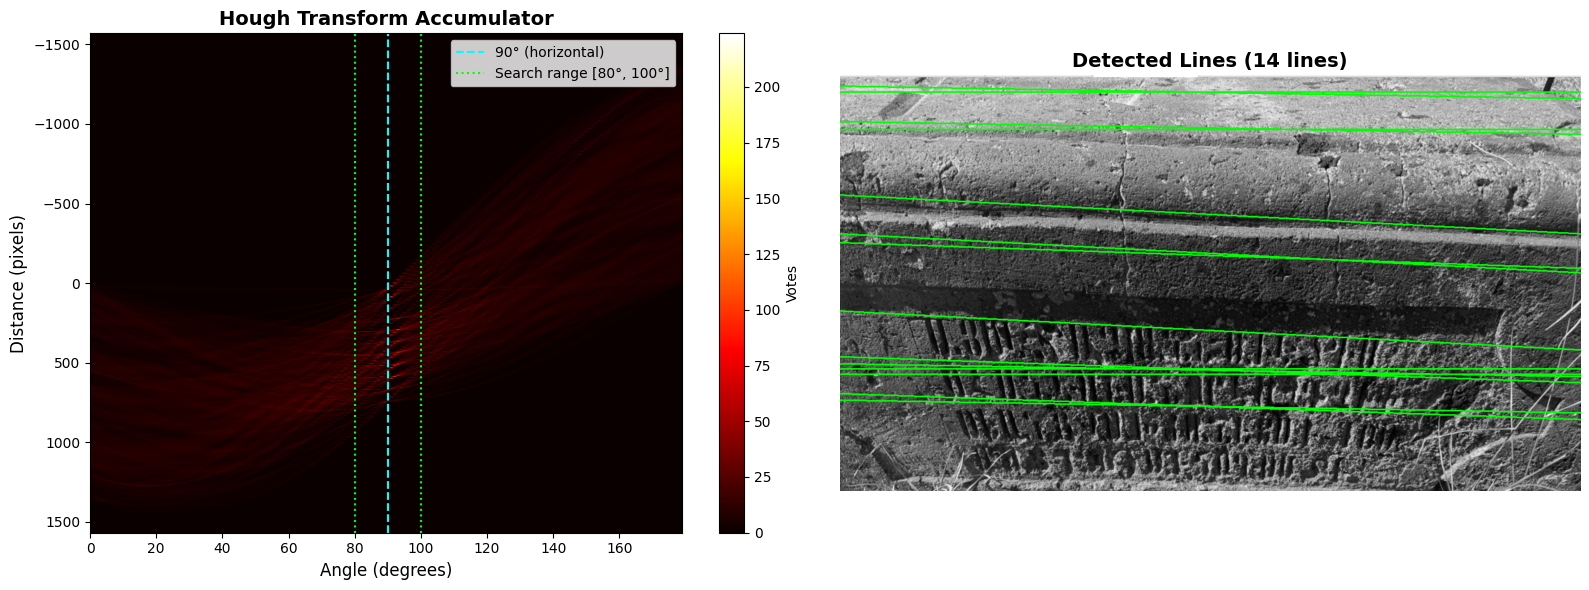


Detected line details:
  Line 1: rho=533.0, angle=91.0°, votes=224
  Line 2: rho=293.0, angle=93.0°, votes=174
  Line 3: rho=600.0, angle=91.0°, votes=153
  Line 4: rho=32.0, angle=90.0°, votes=149
  Line 5: rho=520.0, angle=92.0°, votes=147
  Line 6: rho=588.0, angle=92.0°, votes=141
  Line 7: rho=86.0, angle=91.0°, votes=134
  Line 8: rho=221.0, angle=93.0°, votes=131
  Line 9: rho=101.0, angle=90.0°, votes=124
  Line 10: rho=435.0, angle=93.0°, votes=122
  ... and 4 more lines


In [33]:
# ADJUST PARAMETERS HERE
num_peaks = 20      # Try: 10, 20, 30
angle_min = 80      # Try: 75, 80, 85
angle_max = 100     # Try: 95, 100, 105

# Compute Hough transform
thetas = np.deg2rad(np.arange(0, 180, 1))
hough_space, angles, distances = hough_line(skeleton, theta=thetas)

# Find peaks (detected lines)
h, theta, d = hough_line_peaks(
    hough_space, angles, distances,
    num_peaks=num_peaks
)

# Filter for horizontal lines
detected_lines = []
for votes, angle, rho in zip(h, theta, d):
    angle_deg = np.rad2deg(angle)
    if angle_min <= angle_deg <= angle_max:
        detected_lines.append({
            'rho': rho,
            'theta': angle,
            'votes': votes,
            'angle_deg': angle_deg
        })

print(f"Hough parameters: num_peaks={num_peaks}, angle=[{angle_min}, {angle_max}]")
print(f"Total peaks found: {len(h)}")
print(f"Horizontal lines (within angle range): {len(detected_lines)}")

# Visualize Hough space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hough accumulator
im = axes[0].imshow(
    hough_space,
    extent=[np.rad2deg(angles[0]), np.rad2deg(angles[-1]), distances[-1], distances[0]],
    cmap='hot', aspect='auto'
)
axes[0].set_xlabel('Angle (degrees)', fontsize=12)
axes[0].set_ylabel('Distance (pixels)', fontsize=12)
axes[0].set_title('Hough Transform Accumulator', fontsize=14, fontweight='bold')
axes[0].axvline(90, color='cyan', linestyle='--', label='90° (horizontal)')
axes[0].axvline(angle_min, color='lime', linestyle=':', label=f'Search range [{angle_min}°, {angle_max}°]')
axes[0].axvline(angle_max, color='lime', linestyle=':')
axes[0].legend()
plt.colorbar(im, ax=axes[0], label='Votes')

# Detected lines on original
line_overlay = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2RGB)
for line in detected_lines:
    rho, theta = line['rho'], line['theta']
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 2000 * (-b)), int(y0 + 2000 * a)
    x2, y2 = int(x0 - 2000 * (-b)), int(y0 - 2000 * a)
    cv2.line(line_overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)

axes[1].imshow(line_overlay)
axes[1].set_title(f'Detected Lines ({len(detected_lines)} lines)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print line details
if detected_lines:
    print("\nDetected line details:")
    for i, line in enumerate(detected_lines[:10], 1):  # Show first 10
        print(f"  Line {i}: rho={line['rho']:.1f}, angle={line['angle_deg']:.1f}°, votes={line['votes']}")
    if len(detected_lines) > 10:
        print(f"  ... and {len(detected_lines) - 10} more lines")

**Evaluation:**
- ✓ Good: Green lines align with visible text rows
- ✗ Too many lines: Decrease `num_peaks` or narrow angle range
- ✗ Too few lines: Increase `num_peaks` or go back to improve earlier steps
- ✗ Lines not horizontal: Adjust `angle_min` and `angle_max`

---
## Step 8: Projection Profile & Boundary Detection

**Goal:** Find top/bottom boundaries of each text line

**Parameter:**
- `search_window`: How far to search for valleys around each line (pixels)
- Typical: 30-70

Search window: 50
Text line boundaries found: 18


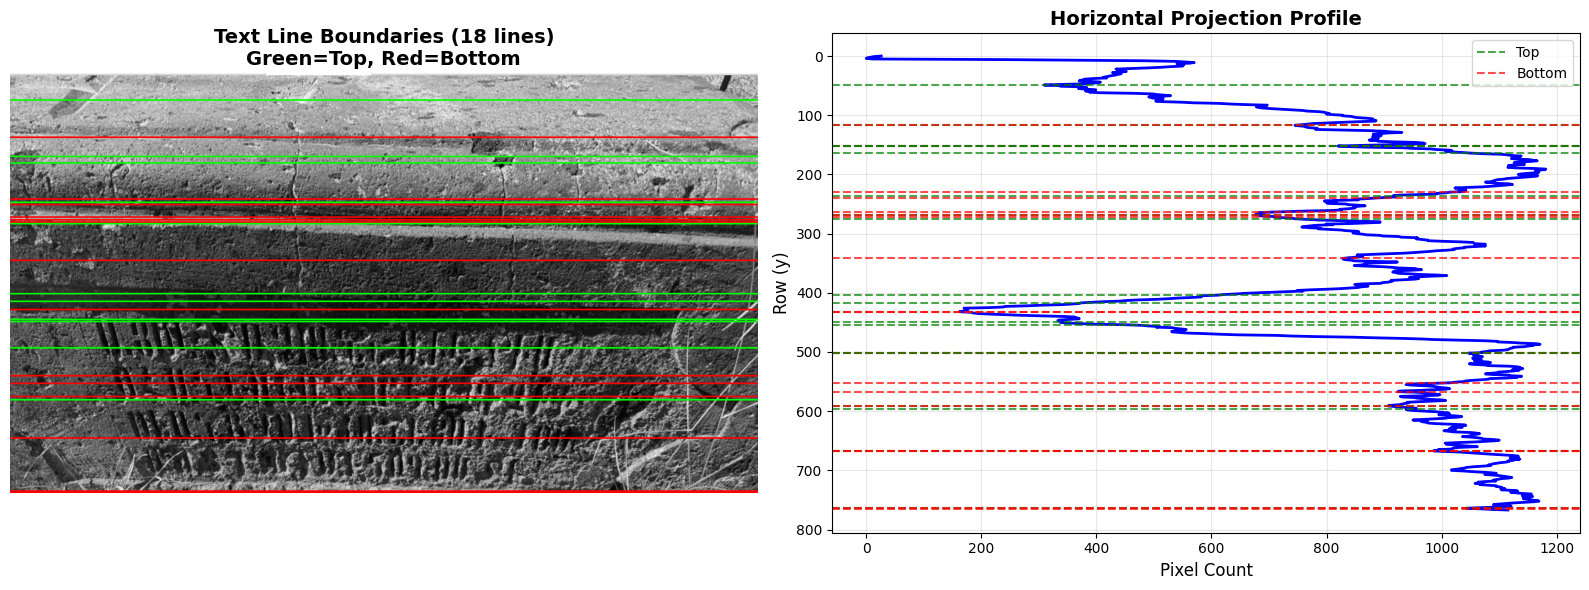

In [12]:
# ADJUST PARAMETER HERE
search_window = 50  # Try: 30, 50, 70

# Compute horizontal projection
projection = np.sum(denoised > 0, axis=1)

# Extract line positions from detected lines
line_positions = [int(line['rho']) for line in detected_lines]

# Find valleys (boundaries) around each line
boundaries = []
for peak_y in line_positions:
    if peak_y < 0 or peak_y >= len(projection):
        continue
    
    # Search upward
    search_start = max(0, peak_y - search_window)
    search_end = peak_y
    top_region = projection[search_start:search_end]
    top_boundary = search_start + np.argmin(top_region) if len(top_region) > 0 else peak_y
    
    # Search downward
    search_start = peak_y
    search_end = min(len(projection), peak_y + search_window)
    bottom_region = projection[search_start:search_end]
    bottom_boundary = search_start + np.argmin(bottom_region) if len(bottom_region) > 0 else peak_y
    
    boundaries.append((top_boundary, bottom_boundary))

# Draw boundaries
boundary_img = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2RGB)
w = boundary_img.shape[1]
for top, bottom in boundaries:
    cv2.line(boundary_img, (0, top), (w, top), (0, 255, 0), 2)      # Green = top
    cv2.line(boundary_img, (0, bottom), (w, bottom), (255, 0, 0), 2)  # Red = bottom

print(f"Search window: {search_window}")
print(f"Text line boundaries found: {len(boundaries)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Image with boundaries
axes[0].imshow(boundary_img)
axes[0].set_title(f'Text Line Boundaries ({len(boundaries)} lines)\nGreen=Top, Red=Bottom', 
                  fontsize=14, fontweight='bold')
axes[0].axis('off')

# Projection profile
axes[1].plot(projection, range(len(projection)), 'b-', linewidth=2)
axes[1].invert_yaxis()
axes[1].set_xlabel('Pixel Count', fontsize=12)
axes[1].set_ylabel('Row (y)', fontsize=12)
axes[1].set_title('Horizontal Projection Profile', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mark boundaries
for i, (top, bottom) in enumerate(boundaries):
    label_top = 'Top' if i == 0 else None
    label_bottom = 'Bottom' if i == 0 else None
    axes[1].axhline(top, color='green', linestyle='--', alpha=0.7, label=label_top)
    axes[1].axhline(bottom, color='red', linestyle='--', alpha=0.7, label=label_bottom)

if boundaries:
    axes[1].legend()

plt.tight_layout()
plt.show()

**Evaluation:**
- ✓ Good: Boundaries align with top/bottom of text lines
- ✗ Boundaries too tight: Increase `search_window`
- ✗ Boundaries too loose: Decrease `search_window`

---
## Final Comparison


Complete Pipeline Results for: Image1


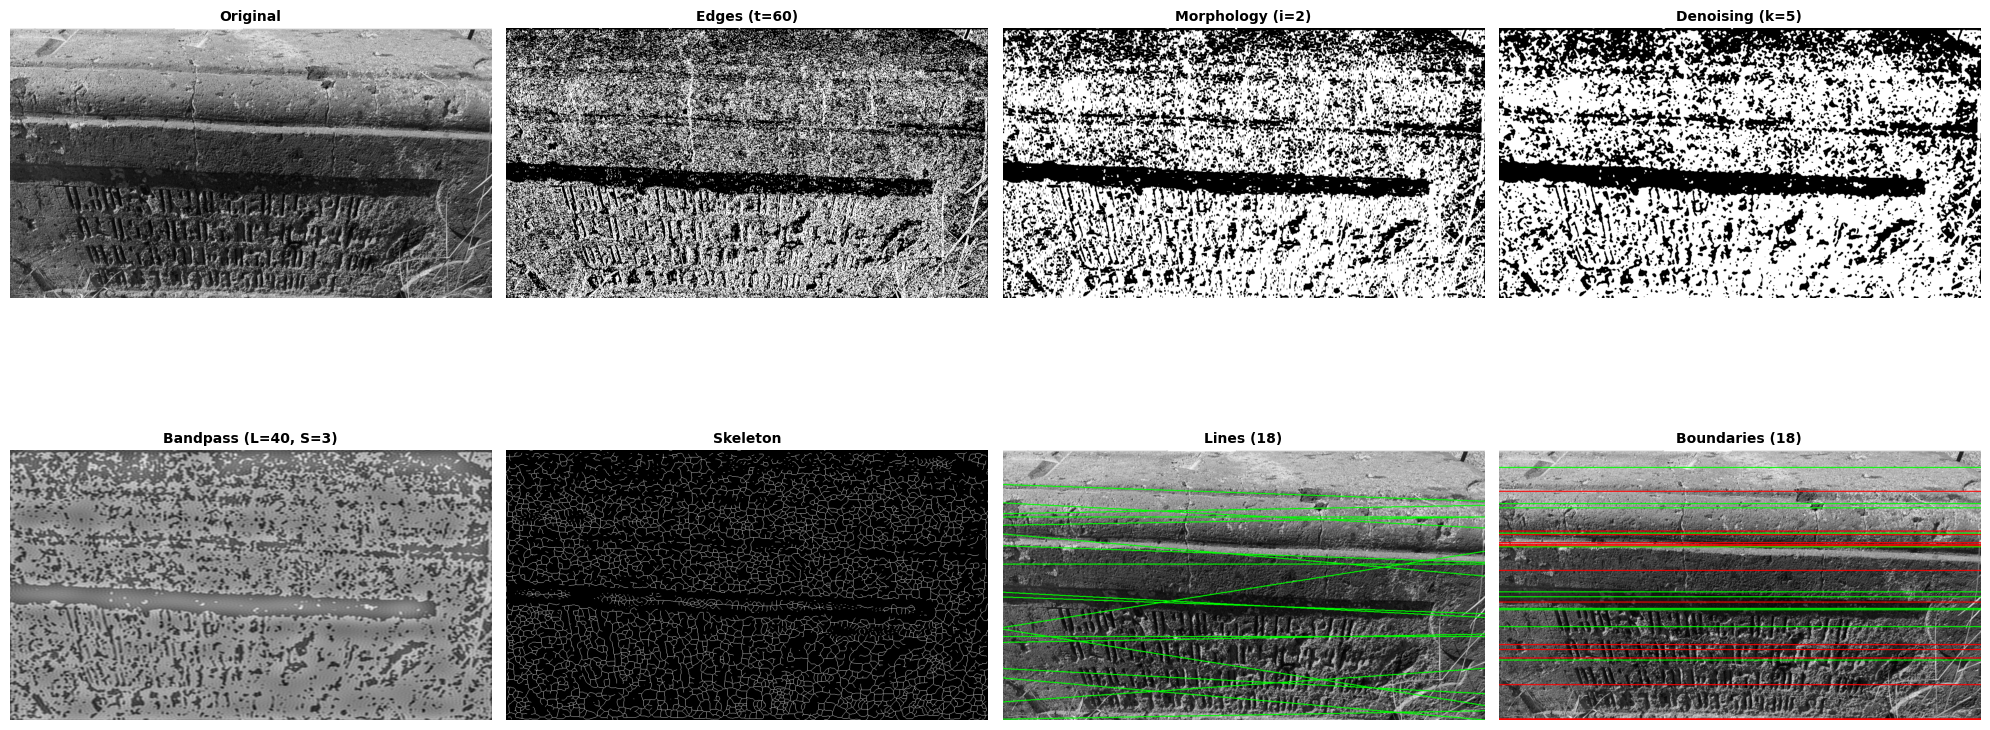


Pipeline Statistics:
  Image: Image1
  Size: (768, 1369)
  Edge pixels: 463,598
  Particles: 66
  Lines detected: 18
  Boundaries: 18

Current Parameters:
  edge_threshold = 60
  morph_iterations = 2
  denoise_kernel = 5
  filter_large = 40
  filter_small = 3
  min_particle_size = 100
  num_peaks = 20
  angle_range = [80, 100]
  search_window = 50


In [13]:
# Show complete pipeline progression
print(f"\nComplete Pipeline Results for: {SELECTED_IMAGE}")
print("="*70)

show_grid(
    [
        original_gray,
        combined_edges,
        morphed,
        denoised,
        bandpass,
        skeleton,
        line_overlay,
        boundary_img
    ],
    [
        'Original',
        f'Edges (t={edge_threshold})',
        f'Morphology (i={morph_iterations})',
        f'Denoising (k={denoise_kernel})',
        f'Bandpass (L={filter_large}, S={filter_small})',
        'Skeleton',
        f'Lines ({len(detected_lines)})',
        f'Boundaries ({len(boundaries)})'
    ],
    cols=4, figsize=(20, 10)
)

print("\nPipeline Statistics:")
print(f"  Image: {SELECTED_IMAGE}")
print(f"  Size: {original_gray.shape}")
print(f"  Edge pixels: {edge_pixels:,}")
print(f"  Particles: {len(particles)}")
print(f"  Lines detected: {len(detected_lines)}")
print(f"  Boundaries: {len(boundaries)}")
print("\nCurrent Parameters:")
print(f"  edge_threshold = {edge_threshold}")
print(f"  morph_iterations = {morph_iterations}")
print(f"  denoise_kernel = {denoise_kernel}")
print(f"  filter_large = {filter_large}")
print(f"  filter_small = {filter_small}")
print(f"  min_particle_size = {min_particle_size}")
print(f"  num_peaks = {num_peaks}")
print(f"  angle_range = [{angle_min}, {angle_max}]")
print(f"  search_window = {search_window}")

---
## FINAL: Export Results to Timestamped Folder

**Run this cell only when you are satisfied with the results!**

This will create a new timestamped folder in `Results/` and save all intermediate images.

In [14]:
# Create timestamped folder
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = RESULTS_DIR / f"export_{timestamp}_{SELECTED_IMAGE}"
export_dir.mkdir(parents=True, exist_ok=True)

print(f"Exporting results to: {export_dir}")
print("="*70)

# Helper function to save
def save_result(img, filename):
    filepath = export_dir / filename
    if len(img.shape) == 2:  # Grayscale
        cv2.imwrite(str(filepath), img)
    else:  # Color (RGB)
        cv2.imwrite(str(filepath), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"  ✓ {filename}")

# Save all intermediate results
print("\nSaving images...")
save_result(original_gray, "00_original.png")
save_result(combined_edges, "01_edges_combined.png")
save_result(east_edges, "01_edges_east.png")
save_result(west_edges, "01_edges_west.png")
save_result(dilated, "02_morphology_dilated.png")
save_result(morphed, "02_morphology_final.png")
save_result(denoised, "03_denoised.png")
save_result(bandpass, "04_bandpass.png")
save_result(ellipse_img, "05_particles.png")
save_result(skeleton, "06_skeleton.png")
save_result(line_overlay, "07_lines.png")
save_result(boundary_img, "08_boundaries.png")

# Save comparison image
comparison = np.hstack([
    cv2.cvtColor(original_gray, cv2.COLOR_GRAY2RGB),
    line_overlay,
    boundary_img
])
save_result(comparison, "09_final_comparison.png")

# Save parameters and statistics
report_path = export_dir / "parameters_and_stats.txt"
with open(report_path, 'w') as f:
    f.write(f"Armenian Inscription Analysis - {SELECTED_IMAGE}\n")
    f.write(f"Export Timestamp: {timestamp}\n")
    f.write("="*70 + "\n\n")
    
    f.write("PARAMETERS USED:\n")
    f.write("-"*70 + "\n")
    f.write(f"edge_threshold = {edge_threshold}\n")
    f.write(f"morph_iterations = {morph_iterations}\n")
    f.write(f"denoise_kernel = {denoise_kernel}\n")
    f.write(f"filter_large = {filter_large}\n")
    f.write(f"filter_small = {filter_small}\n")
    f.write(f"min_particle_size = {min_particle_size}\n")
    f.write(f"num_peaks = {num_peaks}\n")
    f.write(f"angle_range = [{angle_min}, {angle_max}]\n")
    f.write(f"search_window = {search_window}\n")
    f.write("\n")
    
    f.write("STATISTICS:\n")
    f.write("-"*70 + "\n")
    f.write(f"Image size: {original_gray.shape}\n")
    f.write(f"Edge pixels: {edge_pixels:,} ({edge_percent:.2f}%)\n")
    f.write(f"Morphed pixels: {morph_pixels:,}\n")
    f.write(f"Denoised pixels: {denoised_pixels:,}\n")
    f.write(f"Skeleton pixels: {skeleton_pixels:,}\n")
    f.write(f"Particles detected: {len(particles)}\n")
    f.write(f"Lines detected: {len(detected_lines)}\n")
    f.write(f"Boundaries found: {len(boundaries)}\n")
    f.write("\n")
    
    f.write("DETECTED LINES:\n")
    f.write("-"*70 + "\n")
    for i, line in enumerate(detected_lines, 1):
        f.write(f"Line {i}: rho={line['rho']:.1f}, angle={line['angle_deg']:.1f}°, votes={line['votes']}\n")
    f.write("\n")
    
    f.write("BOUNDARIES:\n")
    f.write("-"*70 + "\n")
    for i, (top, bottom) in enumerate(boundaries, 1):
        height = bottom - top
        f.write(f"Boundary {i}: top={top}, bottom={bottom}, height={height}\n")

print(f"\n  ✓ parameters_and_stats.txt")

print("\n" + "="*70)
print("EXPORT COMPLETE!")
print("="*70)
print(f"\nResults saved to: {export_dir}")
print(f"\nFiles created:")
for f in sorted(export_dir.glob('*')):
    print(f"  - {f.name}")

Exporting results to: ../Results/export_20251121_124037_Image1

Saving images...
  ✓ 00_original.png
  ✓ 01_edges_combined.png
  ✓ 01_edges_east.png
  ✓ 01_edges_west.png
  ✓ 02_morphology_dilated.png
  ✓ 02_morphology_final.png
  ✓ 03_denoised.png
  ✓ 04_bandpass.png
  ✓ 05_particles.png
  ✓ 06_skeleton.png
  ✓ 07_lines.png
  ✓ 08_boundaries.png
  ✓ 09_final_comparison.png

  ✓ parameters_and_stats.txt

EXPORT COMPLETE!

Results saved to: ../Results/export_20251121_124037_Image1

Files created:
  - 00_original.png
  - 01_edges_combined.png
  - 01_edges_east.png
  - 01_edges_west.png
  - 02_morphology_dilated.png
  - 02_morphology_final.png
  - 03_denoised.png
  - 04_bandpass.png
  - 05_particles.png
  - 06_skeleton.png
  - 07_lines.png
  - 08_boundaries.png
  - 09_final_comparison.png
  - parameters_and_stats.txt


---
## Process Another Image?

To process a different image:
1. Go back to the "Step 0" section
2. Change `SELECTED_IMAGE` to another image name
3. Re-run all cells from Step 0 onwards
4. Adjust parameters as needed for the new image
5. Export when satisfied